In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
import matplotlib.cm as cm

from scipy.spatial.distance import cdist

import json

from os.path import join

In [95]:
ARTIST_PATH = './artist_df.csv'
artist_df = pd.read_csv(ARTIST_PATH)

In [97]:
def make_artist_graph(path, similarity_matrix=None, edge_weight_threshold=0.1):
    artist_df = pd.read_csv(path)
    # aid -> artist id
    # nid -> node id
    aid_nid_map = {}
    def add_aid_nid_mapping(aid_nid_map, aid, nid):
        aid_nid_map[aid] = nid
        return nid
    artist_df['node_id'] = artist_df.apply(lambda row: add_aid_nid_mapping(aid_nid_map, row['artist_id'], row.name), axis = 1)
    nid_aid_map = {nid: aid for (aid, nid) in aid_nid_map.items()}
    nid_list = artist_df['node_id'].tolist()
    artist_graph = nx.Graph()
    artist_graph.add_nodes_from(artist_df['node_id'].tolist())
    edge_attribute_list = []
    if type(similarity_matrix) != type(None):
        for nid in nid_list[:-1]:
            for other_nid in nid_list[nid+1:]:
                edge_weight = similarity_matrix[nid, other_nid]
                if abs(edge_weight) > edge_weight_threshold:
                    weight_dict = {'weight': edge_weight}
                    edge = (nid, other_nid, weight_dict)
                    edge_attribute_list.append(edge)
        artist_graph.add_edges_from(edge_attribute_list)
    else:
        # Add the node attributes to the graph
        node_attrs_dict = {}
        for nid in nid_list:
            row = artist_df.iloc[nid]
            artist_attr_dict = {
                'artist_name': row['artist_name'],
                'total_plays': row['total_plays'],
                'num_listeners': row['num_listeners'],
                'play_ratio': row['play_ratio']
            }
            genres = row['genres'].replace("[", "").replace("]", "").replace("\'", "").split(', ')
            track_freq = json.loads(row['track_freq'].replace("\'", "\""))
            top_listeners = json.loads(row['top_listeners'].replace("\'", "\""))
            artist_attr_dict['genres'], artist_attr_dict['track_freq'], artist_attr_dict['top_listeners'] = \
            genres, track_freq, top_listeners
            node_attrs_dict[nid] = artist_attr_dict
        nx.set_node_attributes(artist_graph, node_attrs_dict)
        # create edge attributes and add them to the graph
        for nid in nid_list[:-1]:
            for other_nid in nid_list[nid+1:]:
                nid_attr_dict, other_nid_attr_dict = artist_graph.nodes[nid], artist_graph.nodes[other_nid]
                total_plays_abs_diff = abs(nid_attr_dict['total_plays'] - other_nid_attr_dict['total_plays'])
                num_listeners_abs_diff = abs(nid_attr_dict['num_listeners'] - other_nid_attr_dict['num_listeners'])
                play_ratio_abs_diff = abs(nid_attr_dict['play_ratio'] - other_nid_attr_dict['play_ratio'])
                listener_overlap = len(set(nid_attr_dict['top_listeners'].keys()).intersection(
                    set(other_nid_attr_dict['top_listeners'].keys())
                )) - 1
                edge_attr_dict = {
                    'total_plays_abs_diff': total_plays_abs_diff,
                    'num_listeners_abs_diff': num_listeners_abs_diff,
                    'play_ratio_diff': play_ratio_abs_diff,
                    'listerner_overlap': listener_overlap
                }
                edge = (nid, other_nid, edge_attr_dict)
                edge_attribute_list.append(edge)
        artist_graph.add_edges_from(edge_attribute_list)
    return artist_graph, aid_nid_map, nid_aid_map

In [98]:
artist_graph, aid_nid_map, nid_aid_map = make_artist_graph(ARTIST_PATH)

In [99]:
def cluster_count(cluster_label, node_cluster_map):
    count = 0
    for nid, label in node_cluster_map.items():
        if label == cluster_label:
            count += 1
    return count

In [103]:
def calc_majority_labels(df, cluster_node_map, nid_aid_map):
    cluster_majority_label_map = {}
    for cid in cluster_node_map.keys():
        tag_counts = {}
        for nid in cluster_node_map[cid]:
            aid = nid_aid_map[nid]
            tag = df[df['artist_id'] == aid]['tag'].iloc[0]
            if tag in tag_counts:
                tag_counts[tag] += 1
            else:
                tag_counts[tag] = 1
        # calc majority label based on count
        max_label = None
        max_label_count = 0
        for tag, count in tag_counts.items():
            if count >= max_label_count:
                max_label_count = count
                max_label = tag
        
        cluster_majority_label_map[cid] = max_label
        
    return cluster_majority_label_map

def calc_accuracy(actual_tags, predicted_tags):
    N = len(actual_tags)
    num_correct = 0
    for actual, pred in zip(actual_tags, predicted_tags):
        if actual == pred:
            num_correct += 1
    return num_correct/N*100.0

In [101]:
artist_features = artist_df[['total_plays', 'num_listeners', 'play_ratio']].values
correlation_matrix = cdist(artist_features, artist_features, 'correlation')

In [102]:
artist_graph_from_corr, _, _ = make_artist_graph(ARTIST_PATH, similarity_matrix=correlation_matrix)

In [131]:
partition = community_louvain.best_partition(artist_graph_from_corr)

In [132]:
cluster_nodes_mapping = {cid:[] for cid in set(partition.values())}
for nid, cid in partition.items():
    if cid in cluster_nodes_mapping.keys():
        cluster_nodes_mapping[cid].append(nid)

In [133]:
large_clusters = [cid for cid in cluster_nodes_mapping.keys() if len(cluster_nodes_mapping[cid]) > 1]

In [134]:
cluster_majority_label_map = calc_majority_labels(artist_df, cluster_nodes_mapping, nid_aid_map)

In [154]:
clustered_nodes = []
for cid in large_clusters:
    clustered_nodes.extend(cluster_nodes_mapping[cid])

In [155]:
clustered_nodes

[1,
 2,
 6,
 18,
 22,
 25,
 37,
 39,
 44,
 47,
 50,
 53,
 57,
 72,
 75,
 77,
 97,
 105,
 107,
 115,
 122,
 123,
 126,
 5,
 8,
 9,
 11,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 23,
 24,
 26,
 28,
 29,
 30,
 31,
 32,
 35,
 36,
 38,
 40,
 42,
 43,
 46,
 48,
 51,
 52,
 55,
 56,
 58,
 60,
 61,
 62,
 63,
 64,
 65,
 70,
 73,
 74,
 76,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 88,
 90,
 92,
 93,
 94,
 95,
 98,
 100,
 101,
 102,
 106,
 108,
 109,
 110,
 111,
 112,
 114,
 116,
 117,
 118,
 119,
 120,
 124,
 125]

In [141]:
nodes_list = list(nid_aid_map.keys())

In [144]:
nodes_cluster_mapping = {nid:cid for cid in cluster_nodes_mapping.keys() for nid in cluster_nodes_mapping[cid]}
predicted_labels = [cluster_majority_label_map[nodes_cluster_mapping[nid]] for nid in nodes_list]
actual_labels = [artist_df[artist_df['artist_id'] == nid_aid_map[nid]]['tag'].iloc[0] for nid in nodes_list]

In [146]:
accuracy_louvain = calc_accuracy(actual_labels, predicted_labels)

In [147]:
accuracy_louvain

44.881889763779526

In [148]:
clustered_nodes_subgraph = artist_graph_from_corr.subgraph(clustered_nodes)
colors = [nodes_cluster_mapping[nid] for nid in clustered_nodes]

In [149]:
colors

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

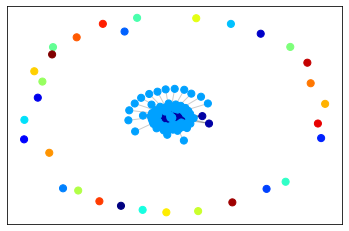

In [150]:
pos = nx.spring_layout(clustered_nodes_subgraph)
# color the nodes according to their partition
nx.draw_networkx_edges(clustered_nodes_subgraph, pos, alpha=0.2)
nx.draw_networkx_nodes(clustered_nodes_subgraph, pos, nodelist=clustered_nodes, node_color=colors, 
                       node_size=50, cmap=plt.cm.jet)
plt.show()

In [151]:
induced_graph = community_louvain.induced_graph(partition, artist_graph_from_corr)

In [152]:
cluster_graph = induced_graph.subgraph(large_clusters)

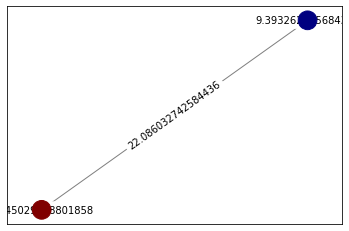

In [153]:
# draw the graph
pos = nx.spring_layout(cluster_graph)
# color the nodes according to their partition
cluster_weights = nx.get_edge_attributes(cluster_graph, 'weight')
nx.draw_networkx_nodes(cluster_graph, pos, nodelist=large_clusters, node_size=350,
                       cmap=plt.cm.jet, node_color=large_clusters)
nx.draw_networkx_edges(cluster_graph, pos, alpha=0.5)
nx.draw_networkx_edge_labels(cluster_graph, pos, edge_labels=cluster_weights)
plt.show()